In [1]:
import pandas as pd
import numpy as np

In [2]:
fx = pd.read_csv(
    'data/EURUSD_1min.txt',
    names = ['day', 'time', 'open',
            'high', 'low', 'close', 'volume'])

fx['datetime'] = fx['day'].astype(str) + " " + fx['time']
fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)

fx = fx.drop(columns = ['day', 'time'])

# Preprocessing

- Step 1: linearly interpolate gaps (shoot, not sure how to do this in parallel besides filling in all gaps and then getting rid of friday -> sunday
- Step 2: so we will go from 21:00 to 21:00 from sunday to friday
    - make a "trading day" feature starting from 21:00 of 
    - get rid of stragler days with no trades at end and beginning if the don't match up right
- Step 3: subtract the day's open at 21:00 from each day (group by day easy) -- let's not honestly...
- Step 4: make relative volume indicator using comparing real volume to groupby day's MA -- yeah I mean for now let's not
- Step 5: 60min HLC

- Step 6: create train, validation and test datasets
- Step 7: divide each column by their std (ungrouped) USING ONLY TRAINING SET MAKING SURE TO SAVE THIS NUMBER -- not for now


Make JSON:
- make the weekday and relative volume a feature
- make inputs_embeds a 2d array containing OHLCV and label 2D array of HLC (no day of week)
- store as JSON

In [3]:
# Linearly interpolate time gaps
fx = fx.set_index('datetime').asfreq('1min')
fx['close'] = fx['close'].fillna(method = 'ffill')
fx['volume'] = fx['volume'].fillna(0) # no volume in gaps (according to first rate data people)

# fill open high and low with most recent close
fx = fx.fillna({
    'open': fx['close'],
    'high': fx['close'],
    'low': fx['close']
})

In [4]:
# define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
fx['day'] = fx.index.dayofweek 
fx.loc[fx.between_time('21:00', '23:59').index, 'day'] += 1
fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

# ordinal trading day since start of data (just for help in preprocessing)
fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()

<AxesSubplot:>

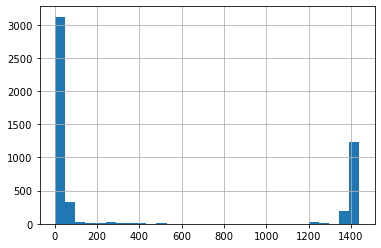

In [5]:
# look at distribution of how many 0 volume minute
(fx['volume'] == 0.).groupby(fx['ordinal_day']).sum().hist(bins = 30)

In [6]:
# let's just arbitrary say there should be less than 100 zero volume -- shouldn't really mattter in the end
voluminous_index = (fx['volume'] == 0.).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 100).index
fx = fx.loc[voluminous_index]

In [7]:
# quick sanity check of data 
fx.between_time('20:59', '21:01').tail(15)

,open,high,low,close,volume,day,ordinal_day
datetime,,,,,,,
2022-09-26 20:59:00,0.96080,0.96093,0.96060,0.96081,50.0,0,5016
2022-09-26 21:00:00,0.96073,0.96090,0.96060,0.96078,26.0,1,5017
2022-09-26 21:01:00,0.96087,0.96090,0.96073,0.96081,15.0,1,5017
2022-09-27 20:59:00,0.95943,0.95946,0.95910,0.95930,54.0,1,5017
2022-09-27 21:00:00,0.95930,0.95940,0.95908,0.95908,20.0,2,5018
2022-09-27 21:01:00,0.95914,0.95920,0.95870,0.95890,10.0,2,5018
2022-09-28 20:59:00,0.97372,0.97388,0.97283,0.97283,138.0,2,5018
2022-09-28 21:00:00,0.97283,0.97358,0.97283,0.97313,13.0,3,5019
2022-09-28 21:01:00,0.97340,0.97350,0.97290,0.97330,9.0,3,5019


In [8]:
# de mean using opening price of day
price_cols = ['open', 'high', 'low', 'close']
fx[price_cols] = fx[price_cols].sub(fx.groupby('ordinal_day')['close'].transform('first'), axis = 0)

In [9]:
future_cols = []
for i in range(1, 61):
    col_name = f'future_close{i}'
    future_cols.append(col_name)
    fx[col_name] = fx['close'] - fx['close'].shift(-i)

In [10]:
# get rid of first and last day due to data incompleteness
fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].min()].index)
fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].max()].index)

In [11]:
# de mean volume using rolling average of day
fx["volume"] = fx['volume'] - fx.groupby('ordinal_day').rolling(5000, min_periods = 0)['volume'].mean().reset_index(drop = True, level = 0)

# Standardizing Data

In [12]:
# only use std based on first 80% of data (to not break test train splitting)
stds = fx.iloc[:4000000].std(axis = 0)
stds

open                0.004577
high                0.004578
low                 0.004583
close               0.004581
volume            145.417872
                     ...    
future_close56      0.002043
future_close57      0.002061
future_close58      0.002079
future_close59      0.002096
future_close60      0.002114
Length: 67, dtype: float64

In [13]:
fx = fx.div(stds, axis = 1)

In [14]:
fx

,open,high,low,close,volume,day,ordinal_day,future_close1,future_close2,future_close3,...,future_close51,future_close52,future_close53,future_close54,future_close55,future_close56,future_close57,future_close58,future_close59,future_close60
datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-04 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003486,0.707721,0.503362,0.825423,...,-0.256339,-0.203109,-0.201201,-0.199348,-0.197546,-0.195787,-0.194081,-0.192417,-0.190796,-0.047303
2009-01-04 21:01:00,0.000000,0.000000,-0.109088,-0.043658,0.017192,0.000000,0.003486,0.000000,0.503362,1.238135,...,-0.307607,-0.304664,-0.301802,-0.299022,-0.296319,-0.293680,-0.291121,-0.288625,-0.143097,-0.189214
2009-01-04 21:02:00,-0.043697,-0.043689,-0.043635,-0.043658,-0.016046,0.000000,0.003486,0.707721,1.510086,1.650846,...,-0.307607,-0.304664,-0.301802,-0.299022,-0.296319,-0.293680,-0.291121,-0.144313,-0.190796,-0.236517
2009-01-04 21:03:00,-0.087394,-0.087378,-0.087270,-0.087316,-0.001719,0.000000,0.003486,1.415441,1.510086,1.444491,...,-0.410143,-0.406218,-0.402402,-0.398697,-0.395091,-0.391573,-0.242601,-0.288625,-0.333893,-0.331124
2009-01-04 21:04:00,-0.131091,-0.109223,-0.174541,-0.174632,0.009627,0.000000,0.003486,0.707721,0.755043,1.238135,...,-0.615214,-0.609327,-0.603604,-0.598045,-0.592637,-0.440520,-0.485201,-0.529147,-0.524689,-0.473035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30 20:55:00,-0.367055,-0.347329,-0.414535,-0.392921,-0.910272,2.836038,4.374928,-0.601562,0.000000,0.206356,...,-1.804628,-1.792438,-1.775601,-1.799118,-1.718648,-1.727816,-1.664240,-1.654786,-1.688544,-1.650892
2022-09-30 20:56:00,-0.369240,-0.286164,-0.414535,-0.355812,-0.669120,2.836038,4.374928,0.601562,0.679539,-0.061907,...,-1.722599,-1.706117,-1.730331,-1.649607,-1.659384,-1.595661,-1.586608,-1.621113,-1.583607,-1.584667
2022-09-30 20:57:00,-0.362685,-0.321116,-0.449443,-0.392921,-1.149691,2.836038,4.374928,0.353860,-0.503362,-3.714404,...,-1.809755,-1.833060,-1.750451,-1.759248,-1.693954,-1.683764,-1.717613,-1.678838,-1.679005,-1.631971


# grouping by days

In [15]:
fx['ohlcv'] = fx[['open', 'high', 'low', 'close', 'volume']].values.tolist()
fx_ohlcv = fx.groupby('ordinal_day')['ohlcv'].agg(lambda x: list(x))

In [16]:
fx_future = pd.Series(fx[future_cols].values.tolist(), index = fx.index)

In [17]:
fx_future = fx_future.groupby(fx['ordinal_day']).agg(lambda x: list(x))

In [18]:
fx_ohlcv

ordinal_day
0.003486    [[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, -0.1090...
0.004357    [[-0.06554552028565579, 0.0, -0.10908805582792...
0.005229    [[0.0655455202857043, 0.10922302271712414, 0.0...
0.006100    [[-0.15293954733319684, 0.04368920908683025, -...
0.006972    [[-0.15293954733319684, 0.04368920908683025, -...
                                  ...                        
4.371442    [[-0.06554552028565579, 0.0, -0.06545283349675...
4.372313    [[-0.01092425338094263, 0.026213525452103002, ...
4.373185    [[0.048066714876152425, 0.06990273453893325, 0...
4.374056    [[-0.06554552028568005, 0.09830072044536807, -...
4.374928    [[-0.06554552028568005, 0.04368920908683025, -...
Name: ohlcv, Length: 3443, dtype: object

In [19]:
fx_future

ordinal_day
0.003486    [[0.7077205688014147, 0.5033619670942626, 0.82...
0.004357    [[1.4154411376028293, 0.5033619670942626, 0.61...
0.005229    [[1.7693014220035368, 1.0067239341885252, 2.47...
0.006100    [[-1.4154411376036151, -0.5033619670942626, -0...
0.006972    [[1.061580853202122, 0.755042950641394, 1.4444...
                                  ...                        
4.371442    [[-0.7077205688014147, -0.3020171802566135, -0...
4.372313    [[-0.1061580853205265, -0.07550429506436293, -...
4.373185    [[0.6369485119215875, 0.4530257703850599, 0.37...
4.374056    [[-0.601562483481281, -0.9312196391244418, -0....
4.374928    [[0.42463234128092736, 2.2399607535698602, -0....
Length: 3443, dtype: object

In [20]:
pd.DataFrame({"ohlcv": fx_ohlcv, "future": fx_future}).to_parquet('data/EURUSD_day.pq', index = False)

In [20]:
# re.split(" |,|\n", foo)[1::6]

In [21]:
# import re
# import numpy as np
# np.array(re.split(" |,|\n", foo)[1::6]).astype(float).mean() / np.array(re.split(" |,|\n", foo)[1::6]).astype(float).std()